In [40]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import re
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
import statsmodels 
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.runs import runstest_1samp

In [41]:
user="Lilian"
years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
#user in personal pc1 <- "asus"

In [42]:
class NDCATCProcessor:

    def __init__(self, year, base_path=None):
        self.year = year
        self.base_path = base_path or rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        
    def clean_sdud_data(self):

        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV: {csv_file}")
        
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        print(f"Initial rows: {len(df):,}")
        
        # Filter data
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions']) #dropping na values
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        
        print(f"After cleaning: {len(df_filtered):,} rows, {df_filtered['NDC'].nunique():,} unique NDCs")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def adding_key(self):
        if self.df_cleaned is None:
            raise ValueError("Run clean_sdud_data() first")
        
        self.df_cleaned['record_id'] = (
            self.df_cleaned['State'].astype(str) + "_" +
            self.df_cleaned['Year'].astype(str) + "_" +
            self.df_cleaned['Quarter'].astype(str) + "_" +
            self.df_cleaned['Utilization Type'].astype(str) + "_" +
            self.df_cleaned['NDC'].astype(str)
        )
        
        print(f"Created {len(self.df_cleaned):,} record IDs")
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        output_filename = output_filename or f"NDCNEW_{self.year}.txt"
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\{output_filename}")
        
        unique_pairs = self.df_cleaned[['NDC', 'record_id']].drop_duplicates()
        
        with open(output_path, 'w') as f:
            f.write("NDC\trecord_id\n")
            for _, row in unique_pairs.iterrows():
                f.write(f"{row['NDC']}\t{row['record_id']}\n")
        
        print(f"Exported {unique_pairs['record_id'].nunique():,} unique records to {output_path}")
        return output_path
    
    #This method was modified by 12/12 to make the table of distribution ATC-level classes before deduplication
    #Therefore, the old method "analyze_atc_distribution" is discarded
    def analyze_atc4_mapping(self):

        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        atc4_path = os.path.join(self.base_path, f"ATC\\ATC4_classes\\NDCNEW_{self.year}_ATC4_classes.csv")
        
        # Load ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object', 'record_id': 'string'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"ATC4 file: {len(df_atc4):,} rows, {df_atc4['NDC'].nunique():,} unique NDCs")
        
        # Ensure consistent types
        self.df_cleaned['record_id'] = self.df_cleaned['record_id'].astype('string')
        self.df_cleaned['NDC'] = self.df_cleaned['NDC'].astype('object')
        
        # Merge on both record_id and NDC
        self.atc_mapping = pd.merge(
            self.df_cleaned,
            df_atc4[['record_id', 'NDC', 'ATC4 Class']],
            on=['record_id', 'NDC'],
            how='left'
        )
        
        # Analyze distribution BEFORE deduplication
        print(f"\n{'='*60}")
        print("DISTRIBUTION ANALYSIS (BEFORE DEDUPLICATION)")
        print(f"{'='*60}")
        
        records = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        if len(records) > 0:
            # Analyze all three ATC levels
            for level in ['ATC4', 'ATC3', 'ATC2']:
                # Create ATC level column if needed
                if level == 'ATC3':
                    records['ATC3 Class'] = records['ATC4 Class'].str[:4]
                    class_col = 'ATC3 Class'
                elif level == 'ATC2':
                    records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                    class_col = 'ATC2 Class'
                else:
                    class_col = 'ATC4 Class'
                
                # Count classes per record_id
                per_record = records.groupby('record_id')[class_col].nunique().reset_index()
                per_record.columns = ['record_id', 'num_classes']
                
                distribution = per_record['num_classes'].value_counts().sort_index()
                
                print(f"\n{level} CLASSES PER RECORD_ID:")
                for n_classes, count in distribution.items():
                    pct = (count / len(per_record)) * 100
                    print(f"  {n_classes} class(es): {count:,} records ({pct:.1f}%)")
                
                print(f"  Avg {level} per record: {per_record['num_classes'].mean():.2f}")
                print(f"  Max {level} per record: {per_record['num_classes'].max()}")
        else:
            print("No records with valid ATC4 mappings found.")
        
        print(f"\n{'='*60}")
        
        # Deduplication after merge by record_id
        before_count = len(self.atc_mapping) 
        self.atc_mapping = self.atc_mapping.drop_duplicates(subset='record_id', keep='first')
        
        total = len(self.atc_mapping)
        mapped = self.atc_mapping['ATC4 Class'].notna().sum()
        print(f"Merged: {total:,} records, {mapped:,} with ATC4 ({mapped/total*100:.1f}%)")
        
        missing = total - mapped
        if missing > 0:
            print(f"Missing: {missing:,} records, {self.atc_mapping[self.atc_mapping['ATC4 Class'].isna()]['NDC'].nunique():,} unique NDCs")
        
        return self.atc_mapping

    def fetch_atc_names(self, cache_path=None):
        """Fetch ATC class names (ATC4, ATC3, ATC2) from RxNav API."""
        if self.atc_mapping is None:
            raise ValueError("Must run analyze_atc4_mapping() first")
        
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        print(f"\n{'='*60}")
        print("FETCHING ATC CLASS NAMES")
        print(f"{'='*60}")
        print(f"Using cache: {cache_path}")
        
        # Get only records with valid ATC4 mappings
        df_with_atc = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df_with_atc['ATC3 Class'] = df_with_atc['ATC4 Class'].str[:4]
        df_with_atc['ATC2 Class'] = df_with_atc['ATC4 Class'].str[:3]
        
        # Get unique codes for each level
        unique_atc4 = df_with_atc['ATC4 Class'].dropna().unique()
        unique_atc3 = df_with_atc['ATC3 Class'].dropna().unique()
        unique_atc2 = df_with_atc['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            
            print("\nFetching ATC4 names...")
            for code in unique_atc4:
                atc4_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC3 names...")
            for code in unique_atc3:
                atc3_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC2 names...")
            for code in unique_atc2:
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply names to all records in atc_mapping
        print("\nApplying names to dataframe...")
        self.atc_mapping['ATC3 Class'] = self.atc_mapping['ATC4 Class'].str[:4]
        self.atc_mapping['ATC2 Class'] = self.atc_mapping['ATC4 Class'].str[:3]
        
        self.atc_mapping['ATC4_Name'] = self.atc_mapping['ATC4 Class'].map(atc4_names).fillna('')
        self.atc_mapping['ATC3_Name'] = self.atc_mapping['ATC3 Class'].map(atc3_names).fillna('')
        self.atc_mapping['ATC2_Name'] = self.atc_mapping['ATC2 Class'].map(atc2_names).fillna('')
        
        print(f"\nATC names added successfully!")
        print("\nSample output:")
        sample = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()][['NDC', 'record_id', 'ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(5)
        print(sample.to_string())
        
        return self.atc_mapping
    
    def prepare_final_dataframe(self):

        if self.atc_mapping is None:
            raise ValueError("Run fetch_atc_names() first")
        
        self.df_merged = self.atc_mapping.copy()
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e9
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e6
        
        total = len(self.df_merged)
        mapped = self.df_merged['ATC4 Class'].notna().sum();
        
        print(f"\nFinal Statistics:")
        print(f"  Records: {total:,} ({mapped:,} with ATC4, {mapped/total*100:.1f}%)")
        print(f"  Units Reimbursed: {self.df_merged['Units Reimbursed'].sum():.2f} Billion")
        print(f"  Prescriptions: {self.df_merged['Number of Prescriptions'].sum():.2f} Million")
        
        return self.df_merged
    
    def _get_atc_name(self, atc_code, cache):
        """Helper: Fetch ATC name from RxNav API with caching."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving {atc_code}: {e}")
            cache[cache_key] = ''
            return ''

    def export_merged_data(self, output_filename=None, show_details=True):

        if self.df_merged is None:
            raise ValueError("Run prepare_final_dataframe() first")
            
        output_filename = output_filename or f"merged_NEWdata_{self.year}.csv"
        output_path = os.path.join(self.base_path, f"ATC\\merged_data\\{output_filename}")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Check duplicates
        initial_count = len(self.df_merged)
        duplicate_count = self.df_merged['record_id'].duplicated().sum()
        
        print(f"\nDeduplication Check:")
        print(f"  Before: {initial_count:,} rows")
        print(f"  Duplicates: {duplicate_count:,}")
        
        # Show sample duplicates if requested
        if show_details and duplicate_count > 0:
            dup_records = self.df_merged[self.df_merged['record_id'].duplicated(keep=False)].sort_values('record_id')
            sample_ids = dup_records['record_id'].unique()[:2]
            
            print(f"\nSample duplicate record_ids:")
            for rid in sample_ids:
                sample = self.df_merged[self.df_merged['record_id'] == rid][
                    ['record_id', 'NDC', 'State', 'ATC4 Class', 'ATC2 Class']
                ]
                print(f"\n{rid}:")
                print(sample.to_string(index=False))
        
        # Deduplicate and export
        df_final = self.df_merged.drop_duplicates(subset='record_id', keep='first')
        df_final.to_csv(output_path, index=False)
        
        print(f"\n  After: {len(df_final):,} rows")
        print(f"  Removed: {initial_count - len(df_final):,}")
        print(f"\nExported to: {output_path}")

        #Showing final atc class mapping in %
        final_count = len(df_final)
        final_mapped_records = df_final['ATC4 Class'].notna().sum()
        #percentages
        print(f"  Mapped Records: {final_mapped_records:,} ({final_mapped_records/final_count*100:.1f}%)")
        final_unmapped_records = final_count - final_mapped_records
        final_mapped_ndcs = df_final[df_final['ATC4 Class'].notna()]['NDC'].nunique()
        final_unmapped_ndcs = df_final['NDC'].nunique()
        
        # Aggregate metrics
        agg = df_final.groupby('record_id').agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        })
        
        print(f"\nAggregated Totals:")
        print(f"  Units Reimbursed: {agg['Units Reimbursed'].sum():.3f} Billion")
        print(f"  Number of Prescriptions: {agg['Number of Prescriptions'].sum():3f} Million")
        
        return output_path

    #New method to see the years trend in mapping
    @staticmethod
    def analyze_merged_data_multi_year(years_list, base_path=None):
    
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("MULTI-YEAR MERGED DATA ANALYSIS")
        print("="*80)
        
        results = {}
        for year in years_list:
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df = pd.read_csv(csv_path)
                
                mapped = df['ATC4 Class'].notna().sum()
                mapped_ndcs = df[df['ATC4 Class'].notna()]['NDC'].nunique()
                total_ndcs = df['NDC'].nunique()
                
                agg = df.groupby('record_id').agg({
                    'Units Reimbursed': 'sum',
                    'Number of Prescriptions': 'sum'
                })
                
                results[year] = {
                    'total_records': len(df),
                    'mapped_records': mapped,
                    'mapping_pct': (mapped / len(df) * 100) if len(df) > 0 else 0,
                    'total_ndcs': total_ndcs,
                    'mapped_ndcs': mapped_ndcs,
                    'ndc_mapping_pct': (mapped_ndcs / total_ndcs * 100) if total_ndcs > 0 else 0,
                    'units_reimbursed': agg['Units Reimbursed'].sum(),
                    'prescriptions': agg['Number of Prescriptions'].sum()
                }
                
                r = results[year]
                print(f"\n{year}: {r['total_records']:,} records | "
                      f"{r['mapped_records']:,} mapped ({r['mapping_pct']:.1f}%) | "
                      f"{r['mapped_ndcs']:,}/{r['total_ndcs']:,} NDCs ({r['ndc_mapping_pct']:.1f}%) | "
                      f"Units: {r['units_reimbursed']:.3f}B | Rx: {r['prescriptions']:.3f}M")
                
            except Exception as e:
                print(f"\n{year}: Error - {e}")
                results[year] = None
        
        # Summary table
        valid = {y: r for y, r in results.items() if r is not None}
        if valid:
            df_summary = pd.DataFrame(valid).T
            print(f"\n{'='*80}\nSUMMARY TABLE\n{'='*80}")
            print(df_summary.to_string())
            
            if len(valid) > 1:
                years = sorted(valid.keys())
                first, last = years[0], years[-1]
                units_chg = (valid[last]['units_reimbursed'] - valid[first]['units_reimbursed']) / valid[first]['units_reimbursed'] * 100
                presc_chg = (valid[last]['prescriptions'] - valid[first]['prescriptions']) / valid[first]['prescriptions'] * 100
                
                print(f"\n{first}→{last}: Units {units_chg:+.1f}%, Prescriptions {presc_chg:+.1f}%")
            
            # Create visualizations
            print(f"\n{'='*80}\nCREATING VISUALIZATIONS\n{'='*80}")
            
            # Extract data for plotting
            years_sorted = sorted(valid.keys())
            total_recs = [valid[y]['total_records']/1e6 for y in years_sorted]
            mapped_recs = [valid[y]['mapped_records']/1e6 for y in years_sorted]
            mapped_ndcs = [valid[y]['mapped_ndcs']/1e3 for y in years_sorted]
            units = [valid[y]['units_reimbursed'] for y in years_sorted]
            prescriptions = [valid[y]['prescriptions'] for y in years_sorted]
            
            # Plot 1: Records and NDCs
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(111)
            ax1_twin = ax1.twinx()
            
            line1 = ax1.plot(years_sorted, total_recs, marker='o', linewidth=2, 
                             label='Total Records', color="#001F47", markersize=8)
            line2 = ax1.plot(years_sorted, mapped_recs, marker='s', linewidth=2, 
                             label='Mapped Records', color="#00039E", markersize=8)
            line3 = ax1_twin.plot(years_sorted, mapped_ndcs, marker='^', linewidth=2, 
                                  label='Mapped NDCs', color="#62B6FF", markersize=8)
            
            ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Records (Millions)', fontsize=11, fontweight='bold', color='black')
            ax1_twin.set_ylabel('Unique NDCs Mapped (Thousands)', fontsize=11, fontweight='bold', color="#000000")
            ax1.set_title('Records and NDC Mapping Trends', fontsize=13, fontweight='bold', pad=15)
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='y', labelcolor='black')
            ax1_twin.tick_params(axis='y', labelcolor="#000000")
            
            lines = line1 + line2 + line3
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
            # Plot 2: Units Reimbursed and Prescriptions
            fig2 = plt.figure(figsize=(10, 6))
            ax2 = fig2.add_subplot(111)
            ax2_twin = ax2.twinx()
            
            line4 = ax2.plot(years_sorted, units, marker='o', linewidth=2, 
                             label='Units Reimbursed', color="#2F2000", markersize=8)
            line5 = ax2_twin.plot(years_sorted, prescriptions, marker='D', linewidth=2, 
                                  label='Prescriptions', color="#A15C23", markersize=8)
            
            ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Units Reimbursed (Billions)', fontsize=11, fontweight='bold', color="#000000")
            ax2_twin.set_ylabel('Number of Prescriptions (Millions)', fontsize=11, fontweight='bold', color="#000000")
            ax2.set_title('UR and NoP Trends', fontsize=13, fontweight='bold', pad=15)
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='y', labelcolor="#000000")
            ax2_twin.tick_params(axis='y', labelcolor="#000000")
            
            lines2 = line4 + line5
            labels2 = [l.get_label() for l in lines2]
            ax2.legend(lines2, labels2, loc='upper left', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
            print("✓ Visualizations created successfully")
        
        return results
    

In [43]:
#Calling the method export_merged_data
#processor = NDCATCProcessor(year=2017)
#processor.clean_sdud_data()           # Clean SDUD data
#processor.adding_key()                # Add record_id key
#analyzer.generate_ndc_txt()          # Generate NDC text file
#processor.analyze_atc4_mapping()
#processor.fetch_atc_names()           
#processor.prepare_final_dataframe()   
#processor.export_merged_data() 

In [44]:
#results = NDCATCProcessor.analyze_merged_data_multi_year(years_list)

In [ ]:
class NDCATC_overview:

    @staticmethod
    def analyze_general_atc_overview_by_state(years_list, base_path=None, state_filter=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"

        if state_filter:
            if isinstance(state_filter, str):
                state_filter = [state_filter]
            print(f"Creating ATC2 & ATC3 Overview by State for: {', '.join(state_filter)}")
        else:
            print("Creating ATC2 & ATC3 Overview by State (All States)")
        print("="*78)
        
        # Determine if this is national analysis
        is_national_analysis = state_filter is None or len(state_filter) == 0
        
        # Results will be organized by state
        state_results = {}
        all_states = set()
        
        # Collect data for all years first
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    continue
                
                # Filter by state if specified
                if state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        print(f"No records for states {state_filter}")
                        continue
                    states_to_process = state_filter
                else:
                    states_to_process = records['State'].unique()
                    all_states.update(states_to_process)
                
                for state in states_to_process:
                    state_records = records[records['State'] == state]
                    if state_records.empty:
                        continue
                    
                    # Initialize state data structure
                    if state not in state_results:
                        state_results[state] = {
                            'atc2_year_results': {},
                            'atc3_year_results': {}
                        }
                    
                    # ATC2 summary for this state
                    pairs2 = state_records[['record_id', 'NDC', 'ATC2 Class']].drop_duplicates()
                    atc2_summary = pairs2.groupby('ATC2 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc2_summary['Percentage_of_NDCs'] = (
                        atc2_summary['Unique_NDCs'] / pairs2['NDC'].nunique() * 100
                    ).round(1)
                    
                    # ATC3 summary for this state
                    pairs3 = state_records[['record_id', 'NDC', 'ATC3 Class']].drop_duplicates()
                    atc3_summary = pairs3.groupby('ATC3 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc3_summary['Percentage_of_NDCs'] = (
                        atc3_summary['Unique_NDCs'] / pairs3['NDC'].nunique() * 100
                    ).round(1)
                    
                    state_results[state]['atc2_year_results'][year] = atc2_summary
                    state_results[state]['atc3_year_results'][year] = atc3_summary
                
                processed_states = len([s for s in states_to_process if s in state_results])
                print(f"✓ (States: {processed_states})")
                
            except FileNotFoundError:
                print(f"✗ File not found")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # If national analysis, aggregate all states data
        if is_national_analysis:
            print(f"\n{'='*60}")
            print("AGGREGATING NATIONAL DATA FROM ALL STATES")
            print(f"{'='*60}")
            
            # Create aggregated national results
            national_atc2_year_results = {}
            national_atc3_year_results = {}
            
            for year in years_list:
                if year not in [y for state_data in state_results.values() for y in state_data['atc2_year_results'].keys()]:
                    continue
                
                # Aggregate ATC2 data across all states for this year
                atc2_combined = []
                atc3_combined = []
                
                for state, state_data in state_results.items():
                    if year in state_data['atc2_year_results']:
                        df_temp = state_data['atc2_year_results'][year].reset_index()
                        atc2_combined.append(df_temp)
                    if year in state_data['atc3_year_results']:
                        df_temp = state_data['atc3_year_results'][year].reset_index()
                        atc3_combined.append(df_temp)
                
                if atc2_combined:
                    atc2_combined_df = pd.concat(atc2_combined, ignore_index=True)
                    national_atc2_summary = atc2_combined_df.groupby('ATC2 Class').agg(
                        Unique_NDCs=('Unique_NDCs', 'sum'),
                        Total_Records=('Total_Records', 'sum')
                    ).sort_values('Unique_NDCs', ascending=False)
                    total_ndcs = atc2_combined_df['Unique_NDCs'].sum()
                    national_atc2_summary['Percentage_of_NDCs'] = (
                        national_atc2_summary['Unique_NDCs'] / total_ndcs * 100
                    ).round(1)
                    national_atc2_year_results[year] = national_atc2_summary
                
                if atc3_combined:
                    atc3_combined_df = pd.concat(atc3_combined, ignore_index=True)
                    national_atc3_summary = atc3_combined_df.groupby('ATC3 Class').agg(
                        Unique_NDCs=('Unique_NDCs', 'sum'),
                        Total_Records=('Total_Records', 'sum')
                    ).sort_values('Unique_NDCs', ascending=False)
                    total_ndcs = atc3_combined_df['Unique_NDCs'].sum()
                    national_atc3_summary['Percentage_of_NDCs'] = (
                        national_atc3_summary['Unique_NDCs'] / total_ndcs * 100
                    ).round(1)
                    national_atc3_year_results[year] = national_atc3_summary
            
            # Use national aggregated data for processing
            state_results['NATIONAL'] = {
                'atc2_year_results': national_atc2_year_results,
                'atc3_year_results': national_atc3_year_results
            }
            states_to_analyze = ['NATIONAL']
        else:
            states_to_analyze = state_filter
        
        # Process each state (only Indiana or National)
        final_state_results = {}
        
        for state in states_to_analyze:
            if state not in state_results:
                continue
                
            print(f"\n" + "="*60)
            print(f"PROCESSING STATE: {state}")
            print("="*60)
            
            atc2_year_results = state_results[state]['atc2_year_results']
            atc3_year_results = state_results[state]['atc3_year_results']
            
            # Print summaries for this state (same format as original)
            print(f"\nUNIQUE NDCs PER ATC2 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc2_year_results and not atc2_year_results[year].empty:
                    print(f"\n{year}: {len(atc2_year_results[year])} classes, "
                        f"{atc2_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc2_year_results[year].head(10))
            
            print(f"\nUNIQUE NDCs PER ATC3 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc3_year_results and not atc3_year_results[year].empty:
                    print(f"\n{year}: {len(atc3_year_results[year])} classes, "
                        f"{atc3_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc3_year_results[year].head(10))
            
            # Build comparison tables (same logic as original)
            def build_comparison(year_tables):
                all_classes = set()
                for tbl in year_tables.values():
                    if not tbl.empty:
                        all_classes.update(tbl.index.tolist())
                comp = {cls: {y: int(year_tables[y].loc[cls, 'Unique_NDCs']) 
                            if y in year_tables and not year_tables[y].empty and cls in year_tables[y].index else 0
                            for y in years_list}
                        for cls in sorted(all_classes)}
                df = pd.DataFrame(comp).T
                return df.loc[df.sum(axis=1).sort_values(ascending=False).index]
            
            atc2_comparison = build_comparison(atc2_year_results)
            atc3_comparison = build_comparison(atc3_year_results)
            
            # Create cumulative frequency tables (same logic as original)
            def create_cumulative_frequency_table(comparison_df, level_name):
                total_ndcs = comparison_df.sum(axis=1).sort_values(ascending=False)
                
                freq_table = pd.DataFrame({
                    'ATC_Class': total_ndcs.index,
                    'Total_Unique_NDCs': total_ndcs.values,
                    'Percentage': (total_ndcs.values / total_ndcs.sum() * 100).round(2)
                })
                
                freq_table['Cumulative_NDCs'] = freq_table['Total_Unique_NDCs'].cumsum()
                freq_table['Cumulative_Percentage'] = freq_table['Percentage'].cumsum().round(2)
                
                freq_table.reset_index(drop=True, inplace=True)
                freq_table.index = freq_table.index + 1
                
                return freq_table
            
            atc2_freq_table = create_cumulative_frequency_table(atc2_comparison, 'ATC2')
            atc3_freq_table = create_cumulative_frequency_table(atc3_comparison, 'ATC3')
            
            # Store results for this state
            final_state_results[state] = {
                'atc2_year_results': atc2_year_results,
                'atc3_year_results': atc3_year_results,
                'atc2_comparison': atc2_comparison,
                'atc3_comparison': atc3_comparison,
                'atc2_freq_table': atc2_freq_table,
                'atc3_freq_table': atc3_freq_table
            }
            
            # Create line plots for percentage of NDCs over years
            print(f"\n{'='*60}")
            print(f"CREATING VISUALIZATIONS FOR {state}")
            print(f"{'='*60}")
            
            # Helper function to create line plot
            def create_percentage_line_plot(year_results, level_name, state_name, top_n=10):
                """Create line plot showing percentage of NDCs for top classes over years"""
                
                # Collect data for plotting
                plot_data = {}
                years_available = sorted([y for y in years_list if y in year_results and not year_results[y].empty])
                
                if not years_available:
                    print(f"No data available for {level_name} plot")
                    return
                
                # Get top classes based on total NDCs across all years
                all_classes = set()
                for year_df in year_results.values():
                    if not year_df.empty:
                        all_classes.update(year_df.index)
                
                # Calculate total NDCs for each class across all years
                class_totals = {}
                for cls in all_classes:
                    total = 0
                    for year in years_available:
                        if cls in year_results[year].index:
                            total += year_results[year].loc[cls, 'Unique_NDCs']
                    class_totals[cls] = total
                
                # Get top N classes
                top_classes = sorted(class_totals.items(), key=lambda x: x[1], reverse=True)[:top_n]
                top_class_names = [cls for cls, _ in top_classes]
                
                # Build DataFrame for seaborn
                plot_rows = []
                for cls in top_class_names:
                    for year in years_available:
                        if cls in year_results[year].index:
                            pct = year_results[year].loc[cls, 'Percentage_of_NDCs']
                        else:
                            pct = 0
                        plot_rows.append({'Year': year, 'ATC Class': cls, 'Percentage': pct})
                
                plot_df = pd.DataFrame(plot_rows)
                
                # Create the plot using seaborn
                sns.set_style("whitegrid")
                fig, ax = plt.subplots(figsize=(14, 8))
                
                # Select palette based on state name
                # 'husl' provides evenly spaced, perceptually uniform colors
                # that are both distinguishable and visually smooth
                if state_name == 'NATIONAL':
                    palette = sns.color_palette("husl", n_colors=top_n)
                else:
                    palette = sns.color_palette("Set2", n_colors=top_n)
                
                # Use seaborn lineplot
                sns.lineplot(data=plot_df, x='Year', y='Percentage', hue='ATC Class', 
                            marker='o', linewidth=2, markersize=6, ax=ax, 
                            palette=palette)
                
                ax.set_xlabel('Year', fontsize=13, fontweight='bold')
                ax.set_ylabel('Percentage of Unique NDCs (%)', fontsize=13, fontweight='bold')
                ax.set_title(f'{state_name} - Top {top_n} {level_name} Classes by Percentage of NDCs\n(Across Years {years_available[0]}-{years_available[-1]})', 
                            fontsize=14, fontweight='bold', pad=20)
                
                # Move legend outside plot area to the right
                ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, 
                         frameon=True, fancybox=True, shadow=True, title='ATC Class')
                
                # Format y-axis as percentage
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
                
                # Set x-axis to show integer years
                ax.set_xticks(years_available)
                
                plt.tight_layout()
                plt.show()
                
                print(f"✓ {level_name} line plot created")
            
            # Create plots - limit to top 10 for both Indiana and National
            create_percentage_line_plot(atc2_year_results, 'ATC2', state, top_n=10)
            create_percentage_line_plot(atc3_year_results, 'ATC3', state, top_n=10)
        
        return final_state_results
    
    @staticmethod
    def get_atc_ndc_details(year, top_n=10, base_path=None):
    
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
            
        print(f"Analyzing ATC-NDC details for {year}...")
        print("="*60)
        
        try:
            # Load the pre-processed CSV file
            csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
            df_merged = pd.read_csv(csv_path)
            
            records = df_merged[df_merged['ATC4 Class'].notna()].copy()
            if records.empty:
                print("No records with ATC mapping")
                return pd.DataFrame(), pd.DataFrame()
                
            records['ATC2 Class'] = records['ATC4 Class'].str[:3]
            records['ATC3 Class'] = records['ATC4 Class'].str[:4]
            
            # ATC2 details
            atc2_details = records.groupby('ATC2 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            # ATC3 details
            atc3_details = records.groupby('ATC3 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            print(f"\nTop {top_n} ATC2 Classes:")
            print(atc2_details)
            print(f"\nTop {top_n} ATC3 Classes:")
            print(atc3_details)
            
            return atc2_details, atc3_details
            
        except FileNotFoundError:
            print(f"✗ File not found: {csv_path}")
            return pd.DataFrame(), pd.DataFrame()
        except Exception as e:
            print(f"✗ Error: {e}")
            return pd.DataFrame(), pd.DataFrame()
    
    @staticmethod
    def export_cumulative_frequency_excel(years_list, level='ATC2', base_path=None, output_filename=None, 
                                          include_ndc_counts=True, by_state=False, state_filter=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        # Print header
        if by_state:
            states_msg = ', '.join(state_filter) if state_filter else 'All States'
            print(f"Creating {level} Cumulative Frequency Analysis Excel for States: {states_msg}")
        else:
            print(f"Creating {level} Cumulative Frequency Analysis Excel...")
        print("="*70)
        
        # Helper function to create ATC level column
        def create_atc_level_column(df, level):
            if level == 'ATC2':
                return df['ATC4 Class'].str[:3]
            elif level == 'ATC3':
                return df['ATC4 Class'].str[:4]
            else:  # ATC4
                return df['ATC4 Class']
        
        # Helper function to get name mapping
        def get_name_mapping(records, level):
            name_col_map = {'ATC2': 'ATC2_Name', 'ATC3': 'ATC3_Name', 'ATC4': 'ATC4_Name'}
            name_col = name_col_map.get(level)
            
            if name_col and name_col in records.columns:
                return records[['ATC_Level', name_col]].drop_duplicates().set_index('ATC_Level')[name_col].to_dict()
            return {}
        
        # Helper function to process year data
        def process_year_data(csv_path, level, state_filter=None):
            try:
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                
                if records.empty:
                    return None, None, None, None
                
                # Filter by state if needed
                if state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        return None, None, None, None
                
                records['ATC_Level'] = create_atc_level_column(records, level)
                name_mapping = get_name_mapping(records, level)
                
                # Aggregate financial data
                financial = records.groupby('ATC_Level').agg(
                    Units_Reimbursed=('Units Reimbursed', 'sum'),
                    Number_of_Prescriptions=('Number of Prescriptions', 'sum')
                )
                
                # Count unique NDCs
                ndc_counts = records.groupby('ATC_Level').agg(
                    Unique_NDCs=('NDC', 'nunique')
                )
                
                states_processed = records['State'].nunique() if 'State' in records.columns else 1
                
                return financial, ndc_counts, name_mapping, states_processed
                
            except Exception as e:
                print(f"Error processing file: {e}")
                return None, None, None, None
        
        # Collect data for all years
        if by_state:
            state_data = {}  # {state: {year: (financial, ndc_counts, name_mapping)}}
            all_states = set()
        else:
            year_results = {}
            ndc_counts = {}
            name_mapping = {}
        
        # Process each year
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
            
            if by_state:
                # Load full data first
                try:
                    df = pd.read_csv(csv_path)
                    records = df[df['ATC4 Class'].notna()].copy()
                    
                    if state_filter:
                        states_to_process = state_filter if isinstance(state_filter, list) else [state_filter]
                    else:
                        states_to_process = records['State'].unique()
                        all_states.update(states_to_process)
                    
                    for state in states_to_process:
                        financial, ndcs, names, _ = process_year_data(csv_path, level, [state])
                        
                        if financial is not None:
                            if state not in state_data:
                                state_data[state] = {}
                            state_data[state][year] = (financial, ndcs, names)
                    
                    print(f"✓ (States: {len(states_to_process)})")
                except:
                    print("✗")
            else:
                financial, ndcs, names, _ = process_year_data(csv_path, level)
                
                if financial is not None:
                    year_results[year] = financial
                    ndc_counts[year] = ndcs
                    name_mapping.update(names)
                    print(f"✓ ({len(financial)} classes)")
                else:
                    print("✗")
        
        # Helper function to build comparison dataframes
        def build_comparison_dfs(year_financial_dict, year_ndc_dict, years_list):
            # Collect all unique ATC classes
            all_classes = set()
            for df in year_financial_dict.values():
                if df is not None and not df.empty:
                    all_classes.update(df.index)
            for df in year_ndc_dict.values():
                if df is not None and not df.empty:
                    all_classes.update(df.index)
            
            if not all_classes:
                return None, None, None
            
            # Build comparison dictionaries
            units_comp = {}
            presc_comp = {}
            ndc_comp = {}
            
            for cls in sorted(all_classes):
                units_comp[cls] = {
                    y: float(year_financial_dict[y].loc[cls, 'Units_Reimbursed']) 
                    if y in year_financial_dict and year_financial_dict[y] is not None 
                    and not year_financial_dict[y].empty and cls in year_financial_dict[y].index 
                    else 0.0 
                    for y in years_list
                }
                
                presc_comp[cls] = {
                    y: float(year_financial_dict[y].loc[cls, 'Number_of_Prescriptions']) 
                    if y in year_financial_dict and year_financial_dict[y] is not None 
                    and not year_financial_dict[y].empty and cls in year_financial_dict[y].index 
                    else 0.0 
                    for y in years_list
                }
                
                ndc_comp[cls] = {
                    y: int(year_ndc_dict[y].loc[cls, 'Unique_NDCs']) 
                    if y in year_ndc_dict and year_ndc_dict[y] is not None 
                    and not year_ndc_dict[y].empty and cls in year_ndc_dict[y].index 
                    else 0 
                    for y in years_list
                }
            
            # Convert to DataFrames and sort by total units
            units_df = pd.DataFrame(units_comp).T
            presc_df = pd.DataFrame(presc_comp).T
            ndc_df = pd.DataFrame(ndc_comp).T
            
            units_total = units_df.sum(axis=1).sort_values(ascending=False)
            units_df = units_df.loc[units_total.index]
            presc_df = presc_df.loc[units_total.index]
            ndc_df = ndc_df.loc[units_total.index]
            
            return units_df, presc_df, ndc_df
        
        # Helper function to create cumulative frequency DataFrame
        def create_cumulative_df(comparison_df, metric_name, name_mapping):
            totals = comparison_df.sum(axis=1)
            total_sum = totals.sum()
            
            cumulative_total = 0
            df_data = []
            
            for atc_class in comparison_df.index:
                class_total = totals[atc_class]
                cumulative_total += class_total
                percentage = (class_total / total_sum * 100) if total_sum > 0 else 0
                cumulative_pct = (cumulative_total / total_sum * 100) if total_sum > 0 else 0
                
                row = {'ATC_Class': atc_class}
                
                # Add ATC name if available
                row['ATC_Name'] = name_mapping.get(atc_class, '')
                
                # Add year-by-year data
                for year in years_list:
                    if metric_name == 'NDCs':
                        row[f'{metric_name}_{year}'] = int(comparison_df.loc[atc_class, year])
                    else:
                        row[f'{metric_name}_{year}'] = round(comparison_df.loc[atc_class, year], 3)
                
                # Add summary columns
                if metric_name == 'NDCs':
                    row[f'Total_{metric_name}'] = int(class_total)
                    row['Percentage'] = round(percentage, 2)
                    row[f'Cumulative_{metric_name}'] = int(cumulative_total)
                    row['Cumulative_Percentage_NDCs'] = round(cumulative_pct, 2)
                else:
                    row[f'Total_{metric_name}'] = round(class_total, 3)
                    row['Percentage'] = round(percentage, 2)
                    row[f'Cumulative_{metric_name}'] = round(cumulative_total, 3)
                    row['Cumulative_Percentage'] = round(cumulative_pct, 2)
                
                df_data.append(row)
            
            return pd.DataFrame(df_data)
        
        # Export function
        def export_to_excel(units_df, prescriptions_df, ndc_df, output_path, include_ndc_counts):
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                units_df.to_excel(writer, sheet_name='Units_Reimbursed', index=False)
                prescriptions_df.to_excel(writer, sheet_name='Prescriptions', index=False)
                
                if include_ndc_counts:
                    ndc_df.to_excel(writer, sheet_name='NDC_Counts', index=False)
            
            print(f"Exported to Excel: {output_path}")
        
        # Process and export
        output_dir = os.path.join(base_path, "ATC\\exported_analysis")
        os.makedirs(output_dir, exist_ok=True)
        
        if by_state:
            states_to_export = state_filter if state_filter else sorted(all_states)
            all_output_paths = {}
            
            for state in states_to_export:
                if state not in state_data:
                    continue
                
                # Extract data for this state
                state_year_financial = {y: data[0] for y, data in state_data[state].items()}
                state_year_ndc = {y: data[1] for y, data in state_data[state].items()}
                state_name_mapping = {}
                for data in state_data[state].values():
                    state_name_mapping.update(data[2])
                
                # Build comparison DataFrames
                units_comp_df, presc_comp_df, ndc_comp_df = build_comparison_dfs(
                    state_year_financial, state_year_ndc, years_list
                )
                
                if units_comp_df is None:
                    continue
                
                # Create cumulative DataFrames
                units_cum = create_cumulative_df(units_comp_df, 'Units', state_name_mapping)
                presc_cum = create_cumulative_df(presc_comp_df, 'Prescriptions', state_name_mapping)
                ndc_cum = create_cumulative_df(ndc_comp_df, 'NDCs', state_name_mapping)
                
                # Generate output filename
                if output_filename:
                    name_parts = output_filename.rsplit('.', 1)
                    state_output_filename = f"{name_parts[0]}_{state}.{name_parts[1]}"
                else:
                    state_output_filename = f"{level}_Cumulative_Analysis_{state}_with_NDC_Counts.xlsx"
                
                output_path = os.path.join(output_dir, state_output_filename)
                export_to_excel(units_cum, presc_cum, ndc_cum, output_path, include_ndc_counts)
                all_output_paths[state] = output_path
            
            return all_output_paths
        
        else:
            # Build comparison DataFrames
            units_comp_df, presc_comp_df, ndc_comp_df = build_comparison_dfs(
                year_results, ndc_counts, years_list
            )
            
            if units_comp_df is None:
                print("No data found!")
                return None
            
            # Create cumulative DataFrames
            units_cum = create_cumulative_df(units_comp_df, 'Units', name_mapping)
            presc_cum = create_cumulative_df(presc_comp_df, 'Prescriptions', name_mapping)
            ndc_cum = create_cumulative_df(ndc_comp_df, 'NDCs', name_mapping)
            
            # Generate output filename
            if not output_filename:
                output_filename = f"{level}_Cumulative_Analysis_with_NDC_Counts.xlsx"
            
            output_path = os.path.join(output_dir, output_filename)
            export_to_excel(units_cum, presc_cum, ndc_cum, output_path, include_ndc_counts)
            
            return output_path
    
    @staticmethod
    def compare_cumulative_80_analysis(base_path=None, cumulative_threshold=80.0):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print(f"COMPARATIVE ANALYSIS: Indiana vs National ATC2 Classes at {cumulative_threshold}% Threshold")
        print("="*85)
        
        # File paths
        indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
        national_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_with_NDC_Counts.xlsx")
        
        # Load data
        try:
            indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
            indiana_prescriptions = pd.read_excel(indiana_file, sheet_name='Prescriptions')
            national_units = pd.read_excel(national_file, sheet_name='Units_Reimbursed')
            national_prescriptions = pd.read_excel(national_file, sheet_name='Prescriptions')
            
            print(f"✓ Loaded Indiana data: {len(indiana_units)} ATC2 classes")
            print(f"✓ Loaded National data: {len(national_units)} ATC2 classes")
        except FileNotFoundError:
            print("✗ Error: Required Excel files not found. Please run export functions first.")
            return None
        except Exception as e:
            print(f"✗ Error loading files: {e}")
            return None
        
        # Helper function to get classes at threshold
        def get_classes_at_threshold(df, threshold):
            df_sorted = df.sort_values('Cumulative_Percentage').reset_index(drop=True)
            threshold_idx = df_sorted[df_sorted['Cumulative_Percentage'] >= threshold].index
            
            if len(threshold_idx) > 0:
                return df_sorted.iloc[:threshold_idx[0] + 1]['ATC_Class'].tolist()
            return df_sorted['ATC_Class'].tolist()
        
        # Get classes at threshold for each dataset
        in_units_80 = get_classes_at_threshold(indiana_units, cumulative_threshold)
        in_presc_80 = get_classes_at_threshold(indiana_prescriptions, cumulative_threshold)
        nat_units_80 = get_classes_at_threshold(national_units, cumulative_threshold)
        nat_presc_80 = get_classes_at_threshold(national_prescriptions, cumulative_threshold)
        
        # Calculate overlaps
        in_overlap = set(in_units_80) & set(in_presc_80)
        in_only_units = set(in_units_80) - set(in_presc_80)
        in_only_presc = set(in_presc_80) - set(in_units_80)
        
        nat_overlap = set(nat_units_80) & set(nat_presc_80)
        nat_only_units = set(nat_units_80) - set(nat_presc_80)
        nat_only_presc = set(nat_presc_80) - set(nat_units_80)
        
        # Print Indiana Analysis
        print(f"\n{'='*60}")
        print("1. INDIANA ANALYSIS")
        print(f"{'='*60}")
        print(f"\nClasses reaching {cumulative_threshold}% cumulative:")
        print(f"  Units Reimbursed: {len(in_units_80)} classes")
        print(f"  Prescriptions: {len(in_presc_80)} classes")
        print(f"\nComparison:")
        print(f"  Overlap (both metrics): {len(in_overlap)} classes")
        print(f"  Only in Units: {len(in_only_units)} classes")
        print(f"  Only in Prescriptions: {len(in_only_presc)} classes")
        
        # Print National Analysis
        print(f"\n{'='*60}")
        print("2. NATIONAL ANALYSIS")
        print(f"{'='*60}")
        print(f"\nClasses reaching {cumulative_threshold}% cumulative:")
        print(f"  Units Reimbursed: {len(nat_units_80)} classes")
        print(f"  Prescriptions: {len(nat_presc_80)} classes")
        print(f"\nComparison:")
        print(f"  Overlap (both metrics): {len(nat_overlap)} classes")
        print(f"  Only in Units: {len(nat_only_units)} classes")
        print(f"  Only in Prescriptions: {len(nat_only_presc)} classes")
        
        # Helper function for detailed comparison
        def print_detailed_comparison(set1, set2, metric_name):
            overlap = set1 & set2
            only_in = set1 - set2
            only_nat = set2 - set1
            
            print(f"\n{metric_name.upper()} - Detailed Comparison:")
            print("-" * 50)
            print(f"Classes in BOTH Indiana and National ({len(overlap)}):")
            print(f"  {sorted(overlap) if overlap else 'None'}")
            print(f"\nClasses ONLY in Indiana ({len(only_in)}):")
            print(f"  {sorted(only_in) if only_in else 'None'}")
            print(f"\nClasses ONLY in National ({len(only_nat)}):")
            print(f"  {sorted(only_nat) if only_nat else 'None'}")
        
        # Print detailed comparisons
        print(f"\n{'='*85}")
        print("3. DETAILED CLASS ANALYSIS")
        print(f"{'='*85}")
        
        print_detailed_comparison(set(in_units_80), set(nat_units_80), "Units Reimbursed")
        print_detailed_comparison(set(in_presc_80), set(nat_presc_80), "Prescriptions")
        
        # Helper function to calculate category totals
        def get_category_totals(df_units, df_presc, class_list):
            if not class_list:
                return 0.0, 0.0
            units_total = df_units[df_units['ATC_Class'].isin(class_list)]['Total_Units'].sum()
            presc_total = df_presc[df_presc['ATC_Class'].isin(class_list)]['Total_Prescriptions'].sum()
            return units_total, presc_total
        
        # Calculate totals for all categories
        in_units_only_u, in_units_only_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_only_units))
        in_presc_only_u, in_presc_only_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_only_presc))
        in_overlap_u, in_overlap_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_overlap))
        
        nat_units_only_u, nat_units_only_p = get_category_totals(national_units, national_prescriptions, list(nat_only_units))
        nat_presc_only_u, nat_presc_only_p = get_category_totals(national_units, national_prescriptions, list(nat_only_presc))
        nat_overlap_u, nat_overlap_p = get_category_totals(national_units, national_prescriptions, list(nat_overlap))
        
        # Create summary DataFrame
        totals_summary = pd.DataFrame({
            'Geography': ['Indiana', 'Indiana', 'Indiana', 'National', 'National', 'National'],
            'Category': ['Only in Units', 'Only in Prescriptions', 'In Both (Overlap)'] * 2,
            'Num_Classes': [
                len(in_only_units), len(in_only_presc), len(in_overlap),
                len(nat_only_units), len(nat_only_presc), len(nat_overlap)
            ],
            'Total_Units': [
                in_units_only_u, in_presc_only_u, in_overlap_u,
                nat_units_only_u, nat_presc_only_u, nat_overlap_u
            ],
            'Total_Prescriptions': [
                in_units_only_p, in_presc_only_p, in_overlap_p,
                nat_units_only_p, nat_presc_only_p, nat_overlap_p
            ]
        })
        
        print(f"\n{'='*85}")
        print("4. SUMMARY TOTALS")
        print(f"{'='*85}")
        print(totals_summary.to_string(index=False))
        
        # Return comprehensive results
        return {
            'totals_summary': totals_summary,
            'indiana': {
                'units_80': in_units_80,
                'prescriptions_80': in_presc_80,
                'overlap': list(in_overlap),
                'only_units': list(in_only_units),
                'only_prescriptions': list(in_only_presc)
            },
            'national': {
                'units_80': nat_units_80,
                'prescriptions_80': nat_presc_80,
                'overlap': list(nat_overlap),
                'only_units': list(nat_only_units),
                'only_prescriptions': list(nat_only_presc)
            }
        }
    
    @staticmethod
    def create_pareto_charts(base_path=None, top_n=30):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CREATING PARETO CHARTS: Indiana vs National")
        print("="*60)
        
        # File paths
        indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
        national_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_with_NDC_Counts.xlsx")
        
        # Load data
        try:
            indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
            indiana_prescriptions = pd.read_excel(indiana_file, sheet_name='Prescriptions')
            national_units = pd.read_excel(national_file, sheet_name='Units_Reimbursed')
            national_prescriptions = pd.read_excel(national_file, sheet_name='Prescriptions')
            print("✓ Data loaded successfully")
        except FileNotFoundError:
            print("✗ Error: Required Excel files not found. Please run export functions first.")
            return None
        except Exception as e:
            print(f"✗ Error loading files: {e}")
            return None
        
        # Create figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(24, 16))
        
        def create_single_pareto(ax, df, metric_name, geography, top_n):
            """Create a single Pareto chart"""
            df_top = df.head(top_n).copy()
            
            # Prepare data
            classes = df_top['ATC_Class']
            if metric_name == 'Units':
                values = df_top['Total_Units']
                y_label = 'Total Units Reimbursed (Billions)'
            else:
                values = df_top['Total_Prescriptions']
                y_label = 'Total Prescriptions (Millions)'
            
            cumulative_pct = df_top['Cumulative_Percentage']
            
            # Create bar chart
            bars = ax.bar(range(len(classes)), values, alpha=0.7, color='steelblue')
            ax.set_xlabel('ATC2 Classes', fontsize=12)
            ax.set_ylabel(y_label, fontsize=12, color='steelblue')
            ax.tick_params(axis='y', labelcolor='steelblue')
            ax.set_xticks(range(len(classes)))
            ax.set_xticklabels(classes, rotation=90, ha='center', fontsize=8)
            
            # Add value labels on top 3 bars
            for i in range(min(3, len(bars))):
                height = bars[i].get_height()
                ax.text(bars[i].get_x() + bars[i].get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=8)
            
            # Create cumulative percentage line
            ax2 = ax.twinx()
            ax2.plot(range(len(classes)), cumulative_pct, color='red', marker='o', linewidth=2, markersize=3)
            ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(0, 100)
            
            # Add 80% threshold line
            # Add 80% threshold line
            ax2.axhline(y=80, color='red', linestyle='--', alpha=0.7, linewidth=1)
            ax2.text(len(classes)*0.7, 82, '80%', color='red', fontweight='bold')
            
            # Title
            ax.set_title(f'{geography} - {metric_name}\n(Top {top_n} ATC2 Classes)', 
                        fontsize=12, fontweight='bold', pad=15)
        
        # Create all four Pareto charts
        create_single_pareto(axes[0,0], indiana_units, 'Units', 'INDIANA', top_n)
        create_single_pareto(axes[0,1], national_units, 'Units', 'NATIONAL', top_n)
        create_single_pareto(axes[1,0], indiana_prescriptions, 'Prescriptions', 'INDIANA', top_n)
        create_single_pareto(axes[1,1], national_prescriptions, 'Prescriptions', 'NATIONAL', top_n)
        
        plt.tight_layout()
        plt.show()
        
        # Helper function to print Pareto summary
        def print_pareto_summary(df, metric_name, geography):
            df_sorted = df.sort_values('Cumulative_Percentage').reset_index(drop=True)
            threshold_idx = df_sorted[df_sorted['Cumulative_Percentage'] >= 80].index
            
            if len(threshold_idx) > 0:
                classes_80 = df_sorted.iloc[:threshold_idx[0] + 1]
            else:
                classes_80 = df_sorted
            
            total_classes = len(df)
            classes_for_80 = len(classes_80)
            pct_classes_for_80 = (classes_for_80 / total_classes) * 100
            
            if metric_name == 'Units':
                total_value = df['Total_Units'].sum()
                value_80 = classes_80['Total_Units'].sum()
            else:
                total_value = df['Total_Prescriptions'].sum()
                value_80 = classes_80['Total_Prescriptions'].sum()
            
            actual_pct_covered = (value_80 / total_value) * 100
            
            print(f"\n{geography} - {metric_name}:")
            print(f"  Total ATC2 classes: {total_classes}")
            print(f"  Classes needed for ~80%: {classes_for_80} ({pct_classes_for_80:.1f}% of classes)")
            print(f"  Actual coverage: {actual_pct_covered:.1f}%")
            print(f"  Total {metric_name.lower()}: {total_value:.3f}")
            print(f"  Value in top classes: {value_80:.3f}")
            print(f"  Top 5 classes:")
            for i, (_, row) in enumerate(df.head(5).iterrows(), 1):
                value = row['Total_Units'] if metric_name == 'Units' else row['Total_Prescriptions']
                print(f"    {i}. {row['ATC_Class']}: {value:.3f} ({row['Percentage']:.1f}%)")
        
        # Print summaries
        print(f"\n{'='*80}")
        print("PARETO ANALYSIS SUMMARY")
        print(f"{'='*80}")
        
        print_pareto_summary(indiana_units, 'Units', 'INDIANA')
        print_pareto_summary(national_units, 'Units', 'NATIONAL')
        print_pareto_summary(indiana_prescriptions, 'Prescriptions', 'INDIANA')
        print_pareto_summary(national_prescriptions, 'Prescriptions', 'NATIONAL')
        
        # Compare top classes
        print(f"\n{'='*80}")
        print("KEY INSIGHTS - Top 10 Classes Comparison")
        print(f"{'='*80}")
        
        in_top_units = set(indiana_units.head(10)['ATC_Class'])
        nat_top_units = set(national_units.head(10)['ATC_Class'])
        in_top_presc = set(indiana_prescriptions.head(10)['ATC_Class'])
        nat_top_presc = set(national_prescriptions.head(10)['ATC_Class'])
        
        units_overlap = in_top_units & nat_top_units
        presc_overlap = in_top_presc & nat_top_presc
        
        print(f"\nUnits Reimbursed - Common classes: {len(units_overlap)}/10")
        print(f"  Shared: {sorted(units_overlap)}")
        print(f"  Only Indiana: {sorted(in_top_units - nat_top_units)}")
        print(f"  Only National: {sorted(nat_top_units - in_top_units)}")
        
        print(f"\nPrescriptions - Common classes: {len(presc_overlap)}/10")
        print(f"  Shared: {sorted(presc_overlap)}")
        print(f"  Only Indiana: {sorted(in_top_presc - nat_top_presc)}")
        print(f"  Only National: {sorted(nat_top_presc - in_top_presc)}")
        
        return {
            'indiana_units': indiana_units,
            'indiana_prescriptions': indiana_prescriptions,
            'national_units': national_units,
            'national_prescriptions': national_prescriptions
        }

Analyzing Indiana State...
Creating ATC2 & ATC3 Overview by State for: IN
Processing 2017... ✓ (States: 1)
Processing 2018... ✓ (States: 1)
Processing 2019... ✓ (States: 1)
Processing 2020... ✓ (States: 1)
Processing 2021... ✓ (States: 1)
Processing 2022... ✓ (States: 1)
Processing 2023... ✓ (States: 1)
Processing 2024... ✓ (States: 1)

PROCESSING STATE: IN

UNIQUE NDCs PER ATC2 CLASS BY YEAR - IN

2017: 83 classes, 14,325 total NDCs
Top 10:
            Unique_NDCs  Total_Records  Percentage_of_NDCs
ATC2 Class                                                
N06                1151           5811                10.3
N05                 946           4886                 8.5
S01                 808           1952                 7.2
J01                 786           2777                 7.0
N02                 726           2869                 6.5
N03                 509           3040                 4.6
C09                 431           1509                 3.9
D07                 381

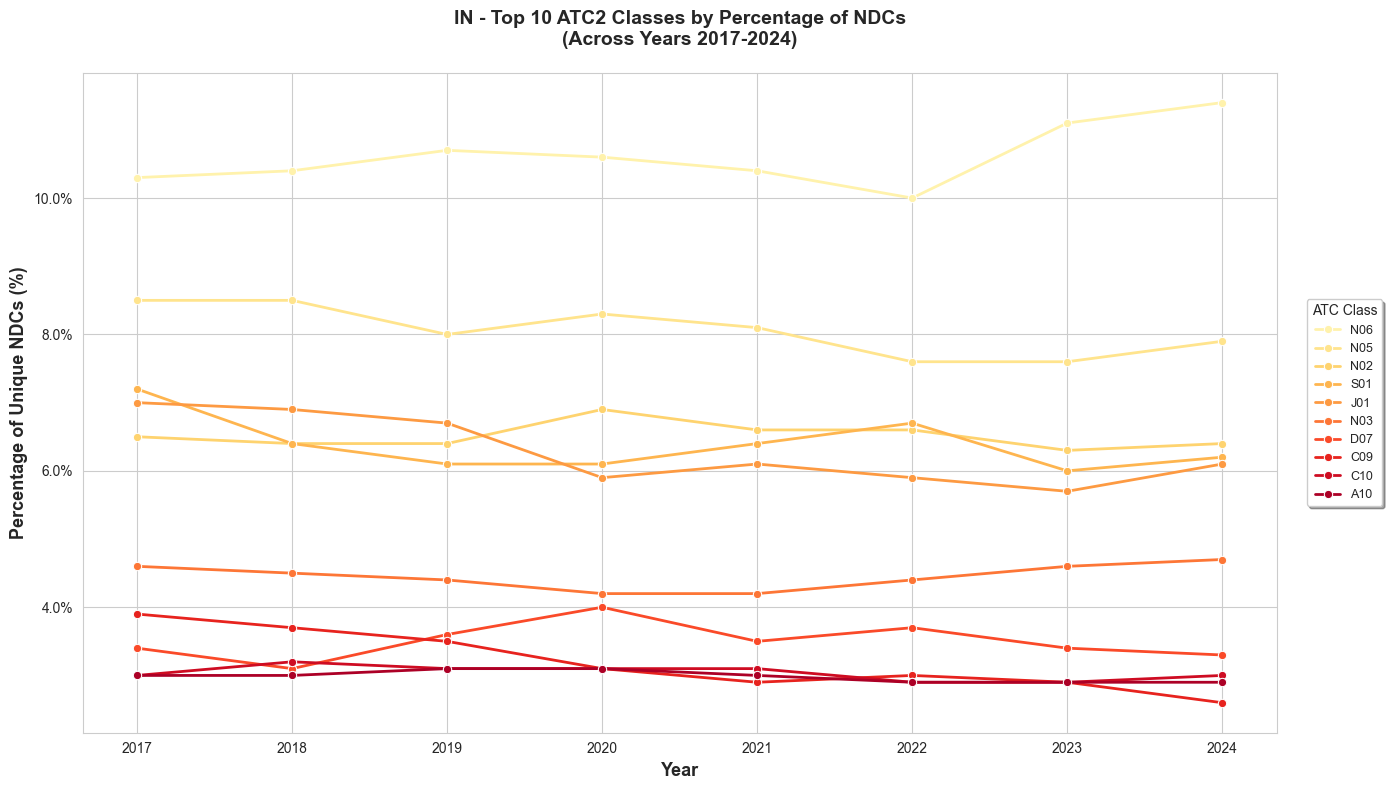

✓ ATC2 line plot created


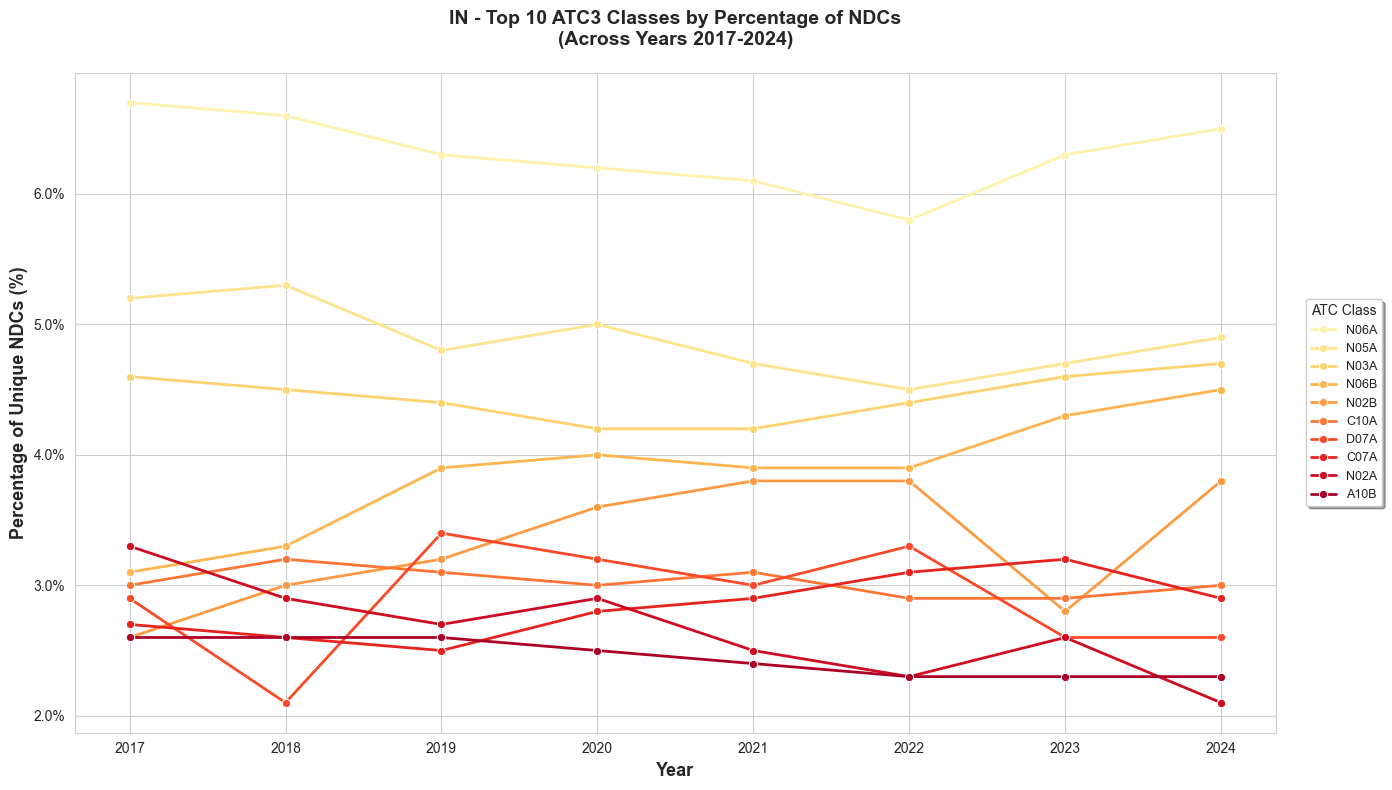

✓ ATC3 line plot created


Analyzing National (All States)...
Creating ATC2 & ATC3 Overview by State (All States)
Processing 2017... ✓ (States: 51)
Processing 2018... ✓ (States: 51)
Processing 2019... ✓ (States: 51)
Processing 2020... ✓ (States: 51)
Processing 2021... ✓ (States: 51)
Processing 2022... ✓ (States: 51)
Processing 2023... ✓ (States: 52)
Processing 2024... ✓ (States: 52)

AGGREGATING NATIONAL DATA FROM ALL STATES

PROCESSING STATE: NATIONAL

UNIQUE NDCs PER ATC2 CLASS BY YEAR - NATIONAL

2017: 88 classes, 574,886 total NDCs
Top 10:
            Unique_NDCs  Total_Records  Percentage_of_NDCs
ATC2 Class                                                
N06               47496         196989                 8.3
N05               41248         177548                 7.2
J01               32923         107069                 5.7
S01               31853          71205                 5.5
N02               28666         108616                 5.0
N03               21181          9658

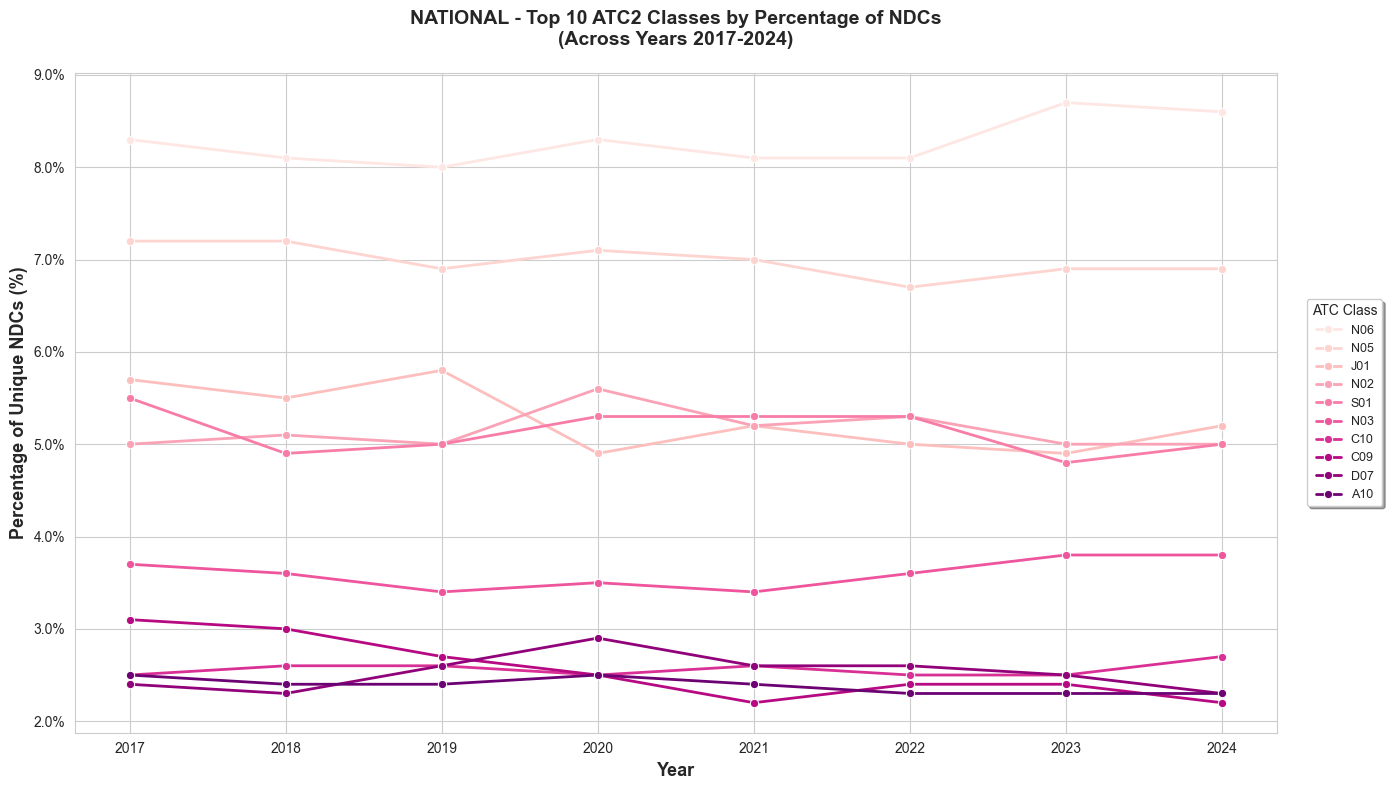

✓ ATC2 line plot created


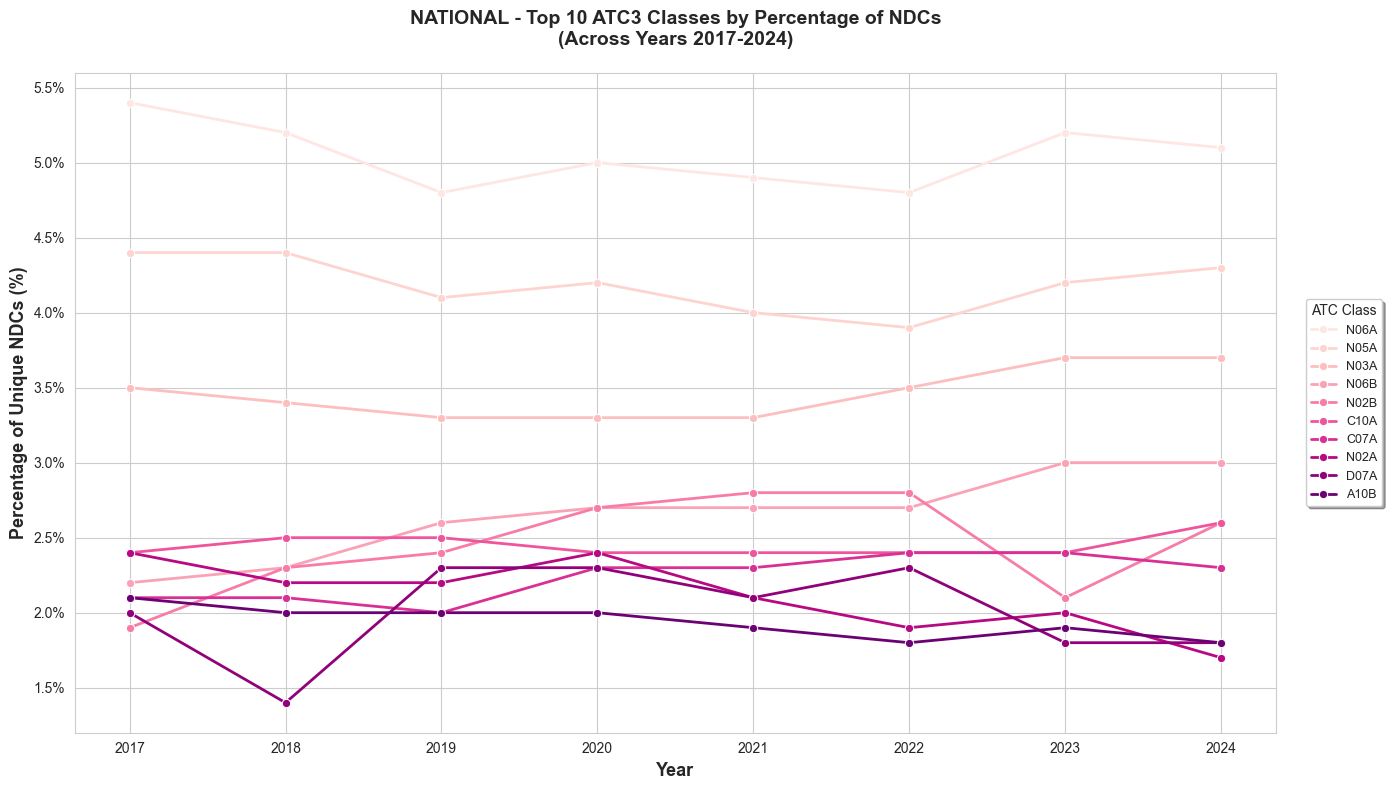

✓ ATC3 line plot created


In [46]:
# Call the method analyze_general_atc_overview_by_state for Indiana
print("Analyzing Indiana State...")
indiana_results = NDCATC_overview.analyze_general_atc_overview_by_state(years_list, state_filter=['IN'])

print("\n" + "="*80 + "\n")

# Call the method analyze_general_atc_overview_by_state for National (all states)
print("Analyzing National (All States)...")
national_results = NDCATC_overview.analyze_general_atc_overview_by_state(years_list)

In [47]:
#Just checking overlap between files with and without key
nokey_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\Classes_notgood\NDCf_2020_ATC4_classes.csv'
keyed_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\NDCNEW_2020_ATC4_classes.csv'
# Load them
keyed = pd.read_csv(keyed_path, dtype=str)
nokey = pd.read_csv(nokey_path, dtype=str)

# Normalize NDCs (remove hyphens, pad to 11 digits)
for df in [keyed, nokey]:
    df["NDC"] = df["NDC"].str.replace("-", "", regex=False).str.zfill(11)

# --- Summary stats ---
summary = {
    "File": ["With key (NDCNEW_2024_ATC4_classes)", "Without key (NDCf_2024_ATC4_classes)"],
    "Total rows": [len(keyed), len(nokey)],
    "Unique NDCs": [keyed["NDC"].nunique(), nokey["NDC"].nunique()],
    "Mapped NDCs (non-null ATC)": [
        keyed["ATC4 Class"].notna().sum(),
        nokey["ATC4 Class"].notna().sum(),
    ],
}
summary_df = pd.DataFrame(summary)

# --- Compare overlap of unique NDCs ---
ndc_keyed = set(keyed["NDC"].unique())
ndc_nokey = set(nokey["NDC"].unique())

overlap_ndcs = len(ndc_keyed & ndc_nokey)
only_in_nokey = len(ndc_nokey - ndc_keyed)
only_in_keyed = len(ndc_keyed - ndc_nokey)

comparison = pd.DataFrame({
    "Metric": ["Overlap NDCs", "Only in without-key file", "Only in with-key file", "Percent overlap"],
    "Value": [overlap_ndcs, only_in_nokey, only_in_keyed, overlap_ndcs / len(ndc_nokey) * 100]
})

print("\n=== Summary of Each File ===")
print(summary_df.to_string(index=False))

print("\n=== NDC Overlap Comparison ===")
print(comparison.to_string(index=False))


=== Summary of Each File ===
                                File  Total rows  Unique NDCs  Mapped NDCs (non-null ATC)
 With key (NDCNEW_2024_ATC4_classes)     4011219        27661                     4011219
Without key (NDCf_2024_ATC4_classes)       54072        27841                       54072

=== NDC Overlap Comparison ===
                  Metric       Value
            Overlap NDCs 27660.00000
Only in without-key file   181.00000
   Only in with-key file     1.00000
         Percent overlap    99.34988


CREATING PARETO CHARTS: Indiana vs National
✓ Data loaded successfully


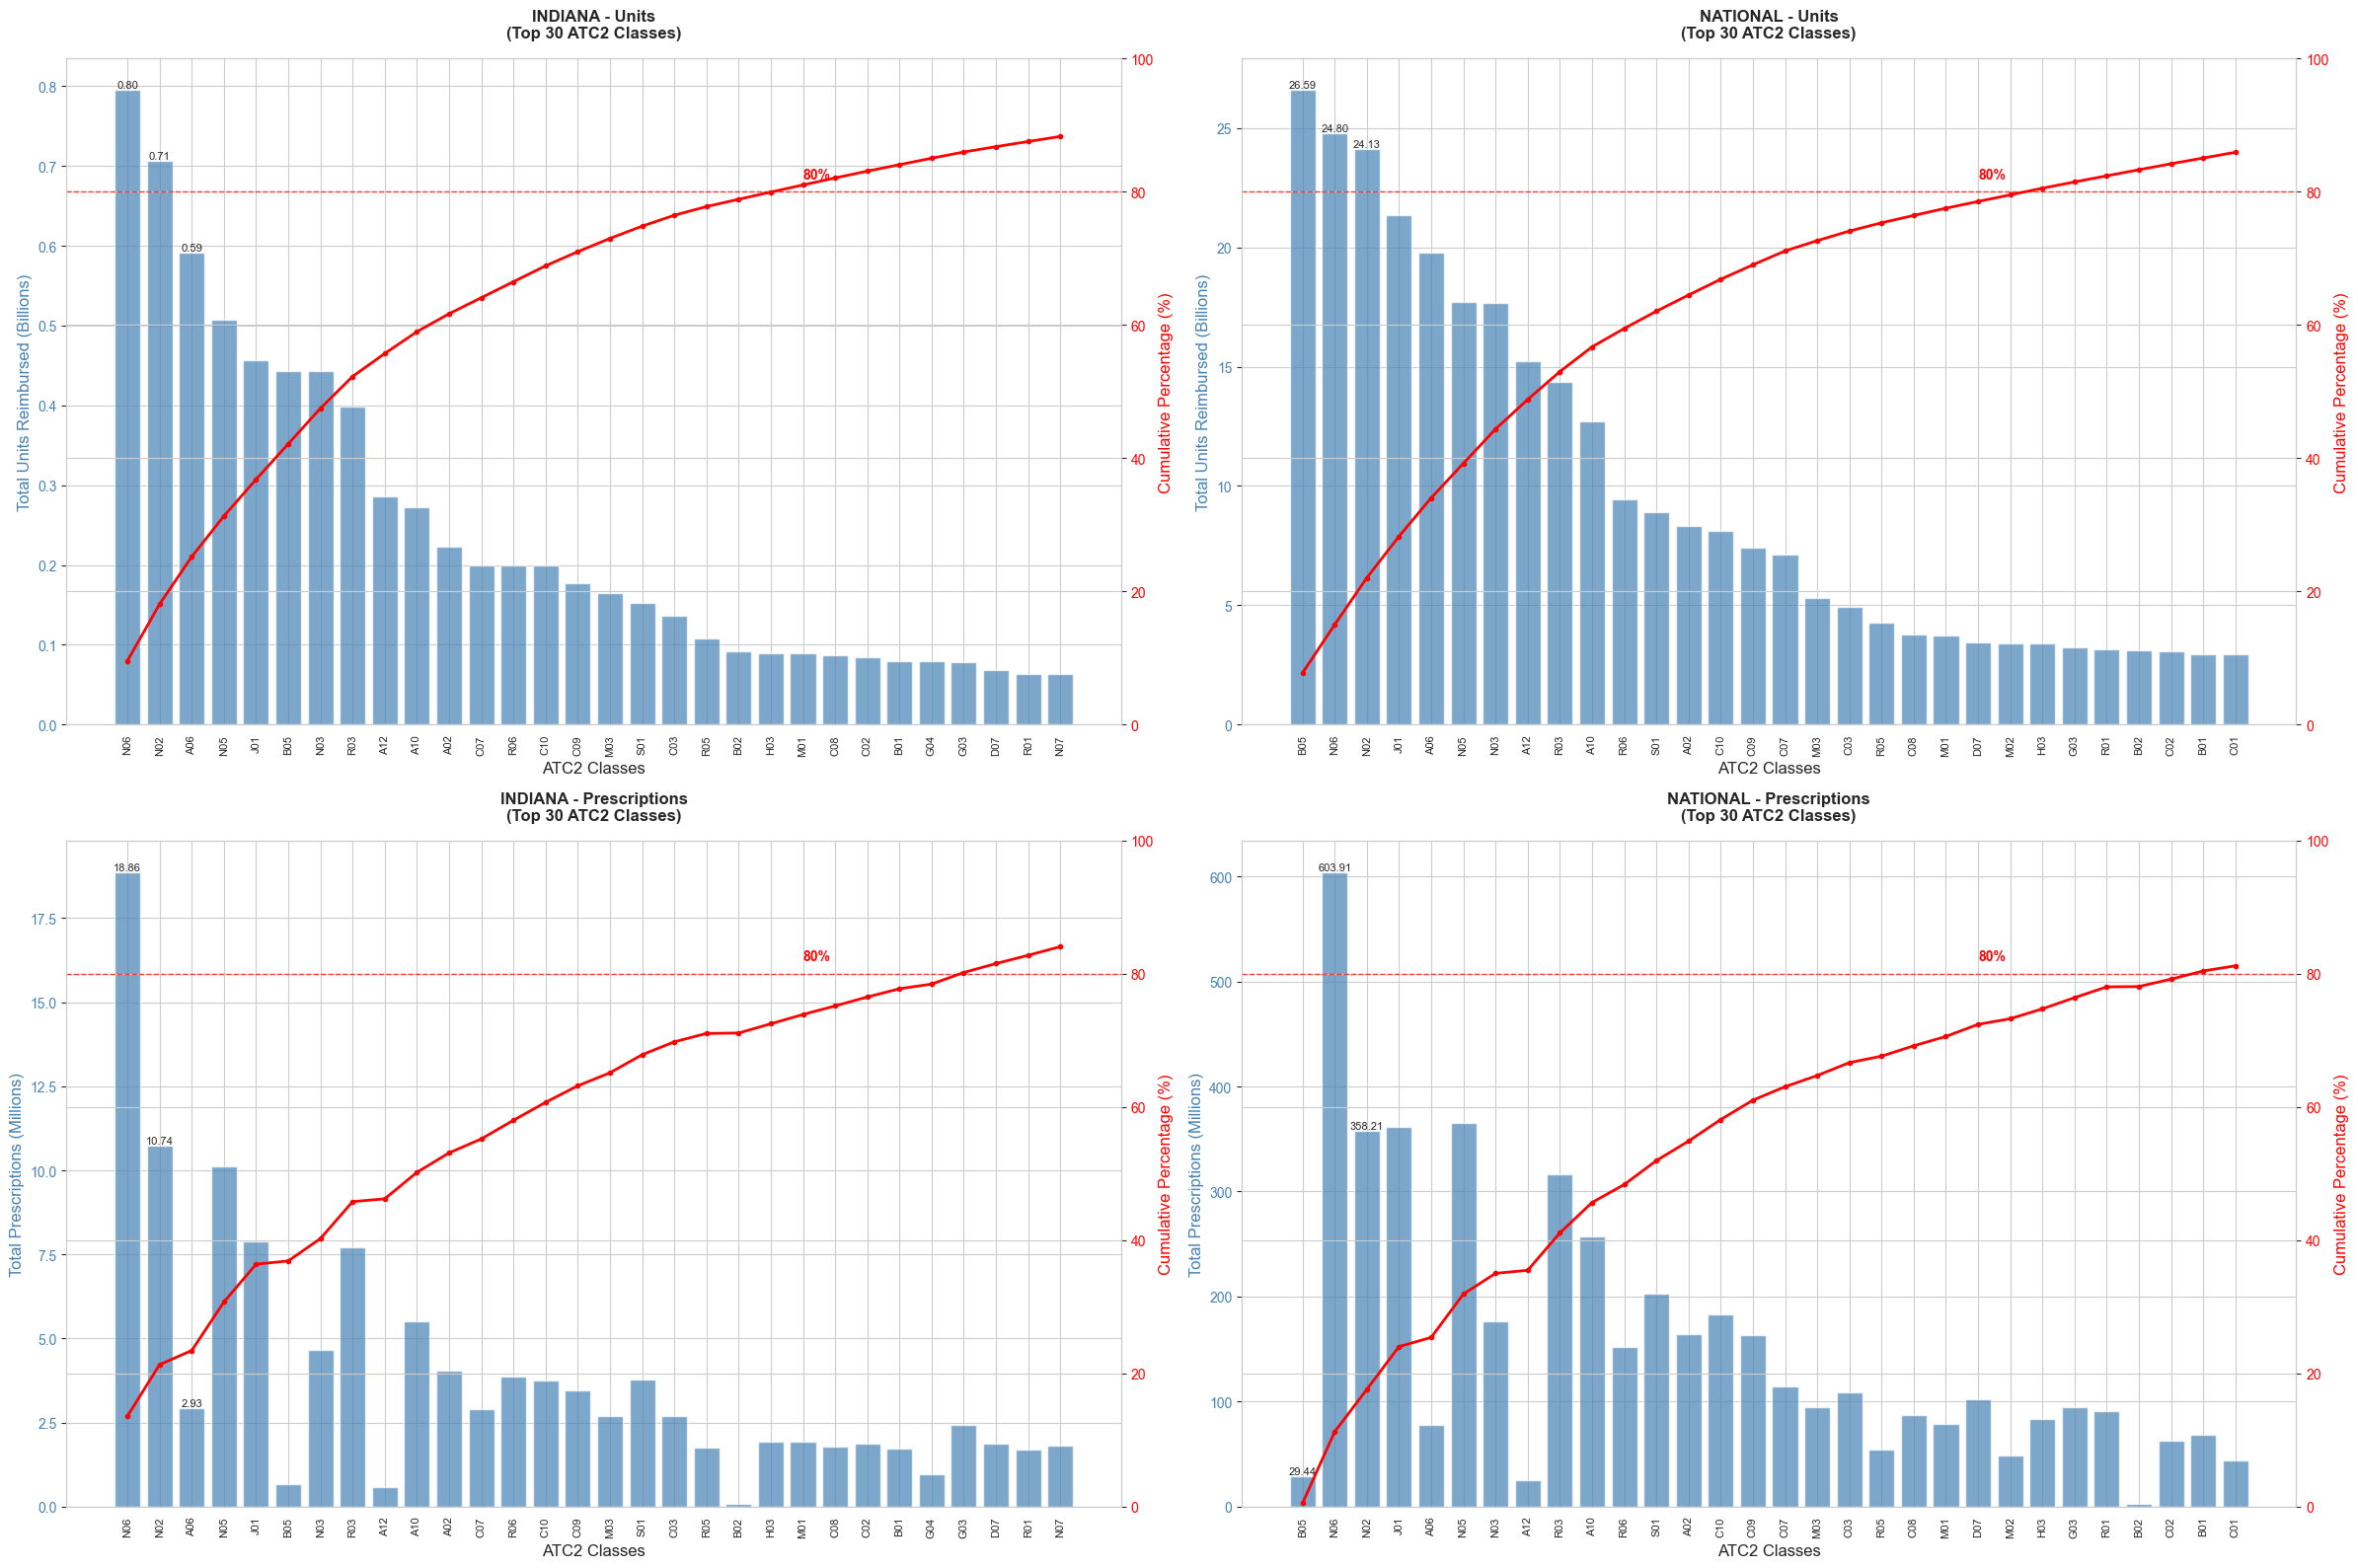


PARETO ANALYSIS SUMMARY

INDIANA - Units:
  Total ATC2 classes: 86
  Classes needed for ~80%: 22 (25.6% of classes)
  Actual coverage: 81.0%
  Total units: 8.308
  Value in top classes: 6.731
  Top 5 classes:
    1. N06: 0.795 (9.6%)
    2. N02: 0.707 (8.5%)
    3. A06: 0.592 (7.1%)
    4. N05: 0.507 (6.1%)
    5. J01: 0.457 (5.5%)

NATIONAL - Units:
  Total ATC2 classes: 90
  Classes needed for ~80%: 24 (26.7% of classes)
  Actual coverage: 80.5%
  Total units: 342.681
  Value in top classes: 275.913
  Top 5 classes:
    1. B05: 26.586 (7.8%)
    2. N06: 24.802 (7.2%)
    3. N02: 24.127 (7.0%)
    4. J01: 21.340 (6.2%)
    5. A06: 19.780 (5.8%)

INDIANA - Prescriptions:
  Total ATC2 classes: 86
  Classes needed for ~80%: 27 (31.4% of classes)
  Actual coverage: 80.2%
  Total prescriptions: 138.831
  Value in top classes: 111.326
  Top 5 classes:
    1. N06: 18.864 (13.6%)
    2. N02: 10.739 (7.7%)
    3. A06: 2.932 (2.1%)
    4. N05: 10.113 (7.3%)
    5. J01: 7.887 (5.7%)

NATIONAL -

In [48]:
ndc_pareto_results = NDCATC_overview.create_pareto_charts()

In [49]:

#Generating only one excel file for all the states
#output_path = NDCATC_overview.export_cumulative_frequency_excel(years_list, by_state=False)  # This combines all states into one analysis
#NDCATC_overview.export_cumulative_frequency_excel(years_list,  level='ATC2','ATC4'by_state=True,state_filter=['IN'])

#print("\nComparing Indiana vs National...")
#ind_vs_national = NDCATC_overview.compare_cumulative_80_analysis()

#ndc_pareto_results = NDCATC_overview.create_pareto_charts()